In [0]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle competitions download -c data-science-bowl-2018
!unzip -q stage1_train.zip -d ./data

  0% 0.00/2.62k [00:00<?, ?B/s]
100% 2.62k/2.62k [00:00<00:00, 2.12MB/s]
  0% 0.00/2.67M [00:00<?, ?B/s]
100% 2.67M/2.67M [00:00<00:00, 88.3MB/s]
 55% 5.00M/9.10M [00:00<00:00, 15.6MB/s]
100% 9.10M/9.10M [00:00<00:00, 23.0MB/s]
 82% 65.0M/79.1M [00:01<00:00, 25.8MB/s]
100% 79.1M/79.1M [00:01<00:00, 49.7MB/s]
  0% 0.00/112k [00:00<?, ?B/s]
100% 112k/112k [00:00<00:00, 84.6MB/s]
 99% 273M/276M [00:05<00:00, 52.7MB/s]
100% 276M/276M [00:05<00:00, 49.6MB/s]
  0% 0.00/386k [00:00<?, ?B/s]
100% 386k/386k [00:00<00:00, 136MB/s]


In [0]:
!kaggle competitions list

In [0]:
!unzip -q stage1_test.zip -d ./test1

In [0]:
from glob import glob 
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm

In [0]:
def reader(directory):
    for folder in tqdm(glob(directory+"/*")):
        local_list = []
        for files in glob(folder+"/masks/*"):
            local_list.append(files)
        combiner(local_list)

def combiner(local_list): 
    temp_img = cv2.imread(local_list[0], 0)
    imgsavepath = local_list[0].split('/')[:-2]
    imgsavepath = '/'.join(imgsavepath)
    imgsavepath = imgsavepath + '/masked.png'
    #/mnt/A00225A9022584FE/Datasets/data-science-bowl-2018/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/masks/
    hook_img = np.zeros(shape=temp_img.shape)
    for index, img_path in enumerate(local_list):
        img = cv2.imread(img_path, 0)
        hook_img += img
    cv2.imwrite(imgsavepath, hook_img)

In [0]:
reader("./data")

100%|██████████| 670/670 [00:29<00:00, 22.76it/s]


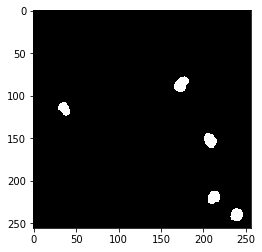

In [0]:
img = cv2.imread("./data/0b2e702f90aee4fff2bc6e4326308d50cf04701082e718d4f831c8959fbcda93/masked.png",  0)
plt.imshow(img, cmap='gray')
plt.show()

In [0]:
!ls data

In [0]:
from glob import glob
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split 
import cv2
import os
import random


def next_batch(num, data, labels):
    idx = np.arange(0, len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]
    return np.asarray(data_shuffle), np.asarray(labels_shuffle)
 
def get_data(directory):
    print("READING DATA")
    image_list = []
    mask_list = []
    for img_file in glob(directory+"/*/images/*.png"):
        # print(img_file)
        # break
#         img = cv2.imread(img_file, 0)
        img = cv2.imread(img_file)
        img = cv2.resize(img, (256, 256))
        image_list.append(img)
    for mask_file in glob(directory+"/*/*.png"):
        # print(mask_file)
        # exit()
        mask = cv2.imread(mask_file, 0)
        mask = cv2.resize(mask, (256, 256))
        mask_list.append(mask)
    print(np.shape(image_list))
    print(np.shape(mask_list))
    assert len(mask_list) == len(image_list)
    np.save('images.npy', image_list)
    np.save('masks.npy', mask_list)
    
    return image_list, mask_list

def train_test_split_data(directory, read_npy=True ):
    if read_npy == False:
        images_list, masks_list = get_data(directory)

    else:
        if os.path.isfile('images.npy') and os.path.isfile('masks.npy'):
            print('DATA EXISTS!')
            images_list = np.load('images.npy')
            print(images_list.shape)
            masks_list = np.load('masks.npy')
            print(masks_list.shape)
        else:
            get_data(directory)
            print('Call TRAIN_TEST_SPLIT_DATA AGAIN!')
            train_test_split_data(directory)
    
    x_train, x_val, y_train, y_val = train_test_split(images_list, masks_list, test_size=0.20, random_state=42)
    x_train = np.asarray(x_train)
    x_val = np.asarray(x_val)
    y_val = np.asarray(y_val)
    y_train = np.asarray(y_train)
    x_train = np.reshape(x_train, (-1, 256, 256, 3))
    x_val = np.reshape(x_val, (-1, 256, 256, 3))
    y_train = np.reshape(y_train, (-1, 256, 256, 1))
    y_val = np.reshape(y_val, (-1, 256, 256, 1))
    print("Done Data Formation.")
    print('X_TRAIN, Y_TRAIN Shape', x_train.shape, y_train.shape)
    print('X_VAL, Y_VAL Shape', x_val.shape, y_val.shape)
    return x_train, x_val, y_train, y_val

In [0]:
x_train, x_val, y_train, y_val = train_test_split_data("./data", read_npy=False )

READING DATA
(670, 256, 256, 3)
(670, 256, 256)
Done Data Formation.
X_TRAIN, Y_TRAIN Shape (536, 256, 256, 3) (536, 256, 256, 1)
X_VAL, Y_VAL Shape (134, 256, 256, 3) (134, 256, 256, 1)


In [0]:
import tensorflow as tf

def conv_conv_pool(input_, n_filters, training, flags, name, pool=True, activation=tf.nn.relu):
    net = input_
    with tf.variable_scope("layer{}".format(name)):
        for i, F in enumerate(n_filters):
            net = tf.layers.conv2d(net, F, (3, 3), activation=None, padding='same', kernel_regularizer=tf.contrib.layers.l2_regularizer(0.1), name="conv_{}".format(i + 1))
            net = tf.layers.batch_normalization(
                net, training=training, name="bn_{}".format(i + 1))
            net = activation(net, name="relu{}_{}".format(name, i + 1))

        if pool is False:
            return net
        pool = tf.layers.max_pooling2d(
            net, (2, 2), strides=(2, 2), name="pool_{}".format(name))
        return net, pool

def upconv_concat(inputA, input_B, n_filter, flags, name):
    up_conv = upconv_2D(inputA, n_filter, flags, name)
    return tf.concat([up_conv, input_B], axis=-1, name="concat_{}".format(name))

def upconv_2D(tensor, n_filter, flags, name):
    return tf.layers.conv2d_transpose(tensor, filters=n_filter, kernel_size=2, strides=2, kernel_regularizer=tf.contrib.layers.l2_regularizer(0.1), name="upsample_{}".format(name))

def make_unet(X, training, flags=None):
    net = X / 127.5 - 1
    conv1, pool1 = conv_conv_pool(net, [8, 8], training, flags, name=1)
    conv2, pool2 = conv_conv_pool(pool1, [16, 16], training, flags, name=2)
    conv3, pool3 = conv_conv_pool(pool2, [32, 32], training, flags, name=3)
    conv4, pool4 = conv_conv_pool(pool3, [64, 64], training, flags, name=4)
    conv5 = conv_conv_pool(pool4, [128, 128], training, flags, name=5, pool=False)
    up6 = upconv_concat(conv5, conv4, 64, flags, name=6)
    conv6 = conv_conv_pool(up6, [64, 64], training, flags, name=6, pool=False)
    up7 = upconv_concat(conv6, conv3, 32, flags, name=7)
    conv7 = conv_conv_pool(up7, [32, 32], training, flags, name=7, pool=False)
    up8 = upconv_concat(conv7, conv2, 16, flags, name=8)
    conv8 = conv_conv_pool(up8, [16, 16], training, flags, name=8, pool=False)
    up9 = upconv_concat(conv8, conv1, 8, flags, name=9)
    conv9 = conv_conv_pool(up9, [8, 8], training, flags, name=9, pool=False)
    return tf.layers.conv2d(conv9, 1, (1, 1), name='final', activation=tf.nn.sigmoid, padding='same')

def build_Uet(X, training):
    input_layer = X / 127.5 - 1
    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(inputs=input_layer, filters=8,kernel_size=[5, 5],padding="same",activation=tf.nn.relu,kernel_regularizer=tf.contrib.layers.l2_regularizer(0.1), name="conv_layer_1")
    bn1 = tf.layers.batch_normalization(conv1, training=training, name="bn_1")
    pool1 = tf.layers.max_pooling2d(bn1, (2, 2), strides=(2, 2), name="pool_1")
    # Convolutional Layer #2
    conv2 = tf.layers.conv2d(inputs=pool1, filters=16,kernel_size=[5, 5],padding="same",activation=tf.nn.relu,kernel_regularizer=tf.contrib.layers.l2_regularizer(0.1), name="conv_layer_2")
    bn2 = tf.layers.batch_normalization(conv2, training=training, name="bn_2")
    pool2 = tf.layers.max_pooling2d(bn2, (2, 2), strides=(2, 2), name="pool_2")
    #Layer 3
    conv3 = tf.layers.conv2d(inputs=pool2, filters=32,kernel_size=[5, 5],padding="same",activation=tf.nn.relu,kernel_regularizer=tf.contrib.layers.l2_regularizer(0.1), name="conv_layer_3")
    bn3 = tf.layers.batch_normalization(conv3, training=training, name="bn_3")
    pool3 = tf.layers.max_pooling2d(bn3, (2, 2), strides=(2, 2), name="pool_3")
    #Layer 4
    conv4 = tf.layers.conv2d(inputs=pool3, filters=64,kernel_size=[5, 5],padding="same",activation=tf.nn.relu,kernel_regularizer=tf.contrib.layers.l2_regularizer(0.1), name="conv_layer_4")
    bn4 = tf.layers.batch_normalization(conv4, training=training, name="bn_4")
    pool4 = tf.layers.max_pooling2d(bn4, (2, 2), strides=(2, 2), name="pool_4")
    #Layer 5
    conv5 = tf.layers.conv2d(inputs=pool4, filters=128,kernel_size=[5, 5],padding="same",activation=tf.nn.relu,kernel_regularizer=tf.contrib.layers.l2_regularizer(0.1), name="conv_layer_5")
    bn5 = tf.layers.batch_normalization(conv5, training=training, name="bn_5")
    
    #Up 6
    up_conv6= tf.layers.conv2d_transpose(bn5, filters=64, kernel_size=2, strides=2, kernel_regularizer=tf.contrib.layers.l2_regularizer(0.1), name="upconv_6")
    concat6 = tf.concat([up_conv6, conv4], axis=-1, name="concat_6")
    conv6 = tf.layers.conv2d(inputs=concat6, filters=32,kernel_size=[5, 5],padding="same",activation=tf.nn.relu,kernel_regularizer=tf.contrib.layers.l2_regularizer(0.1), name="conv_layer_6") 
    bn6 = tf.layers.batch_normalization(conv6, training=training, name="bn_6")
    #Up 7
    up_conv7= tf.layers.conv2d_transpose(bn6, filters=32, kernel_size=2, strides=2, kernel_regularizer=tf.contrib.layers.l2_regularizer(0.1), name="upconv_7")
    concat7 = tf.concat([up_conv7,conv3], axis=-1, name="concat_7")
    conv7 = tf.layers.conv2d(inputs=concat7, filters=32,kernel_size=[5, 5],padding="same",activation=tf.nn.relu,kernel_regularizer=tf.contrib.layers.l2_regularizer(0.1), name="conv_layer_7")
    bn7 = tf.layers.batch_normalization(conv7, training=training, name="bn_7")
    #Up 8
    up_conv8= tf.layers.conv2d_transpose(bn7, filters=16, kernel_size=2, strides=2, kernel_regularizer=tf.contrib.layers.l2_regularizer(0.1), name="upconv_8")
    concat8 = tf.concat([up_conv8, conv2], axis=-1, name="concat_8")
    conv8 = tf.layers.conv2d(inputs=concat8, filters=32,kernel_size=[5, 5],padding="same",activation=tf.nn.relu,kernel_regularizer=tf.contrib.layers.l2_regularizer(0.1), name="conv_layer_8")
    bn8 = tf.layers.batch_normalization(conv8, training=training, name="bn_8")
    #Up 9
    up_conv9= tf.layers.conv2d_transpose(bn8, filters=8, kernel_size=2, strides=2, kernel_regularizer=tf.contrib.layers.l2_regularizer(0.1), name="upconv_9")
    concat9 = tf.concat([up_conv9, conv1], axis=-1, name="concat_9")
    conv9 = tf.layers.conv2d(inputs=concat9, filters=32,kernel_size=[5, 5],padding="same",activation=tf.nn.relu,kernel_regularizer=tf.contrib.layers.l2_regularizer(0.1), name="conv_layer_9")
    bn9 = tf.layers.batch_normalization(conv9, training=training, name="bn_9")
    
    out = tf.layers.conv2d(bn9, 1, (1, 1), name='final', activation=tf.nn.sigmoid, padding='same')

    return out

def IOU_(y_pred, y_true):
    H, W, _ = y_pred.get_shape().as_list()[1:]
    pred_flat = tf.reshape(y_pred, [-1, H * W])
    true_flat = tf.reshape(y_true, [-1, H * W])
    intersection = 10*tf.reduce_sum(pred_flat * true_flat, axis=1) + 1e-7
    union = tf.reduce_sum(pred_flat, axis=1) + tf.reduce_sum(true_flat, axis=1) + 1e-7
    return tf.reduce_mean(intersection / union)

In [0]:
import os
import tensorflow as tf
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
NUM_EPOCHS = 500
BATCH_SIZE = 32
tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape=[None, 256, 256, 3], name="image")
Y = tf.placeholder(tf.float32, shape=[None, 256, 256, 1], name="mask")
isTraining = tf.placeholder(tf.bool, name="iftraining")
global_step = tf.Variable(0, trainable=False, name='global_step')

def build_network(input_images, mask_labels):
     
    logits = build_Uet(input_images, isTraining )
#     logits = make_unet(input_images, isTraining)
    loss = 10-IOU_(logits, mask_labels)
    return loss
    
def train(x_train, x_val, y_train, y_val):
    loss = build_network(X, Y)
    optimizer = tf.train.AdamOptimizer()
    train_op = optimizer.minimize(loss, global_step=global_step)
    summary_op = tf.summary.merge_all()
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    for epoch in range(1, NUM_EPOCHS+1):
        batch_images, batch_labels = next_batch(BATCH_SIZE, x_train, y_train)
        _, train_iou = sess.run([train_op, loss], feed_dict={X: batch_images, Y: batch_labels, isTraining: True})
#         print('Step: {} IOU: {}'.format(epoch, -1*train_iou))
        print('Step: {} loss: {}'.format(epoch, train_iou))

        if epoch % 100 == 0:
            val_iou = sess.run([loss], feed_dict={X: x_val, Y: y_val, isTraining: False})
            print("")
            print("Step: {} Val IOU: {}".format(epoch, val_iou[0]))
#             print("Step: {} Val IOU: {}".format(epoch, -1*val_iou[0]))

            save_path = saver.save(sess, "model/model-epoch{}.ckpt".format(epoch))
            print("Model saved for epoch # {}".format(epoch))
            print("")

In [120]:
if __name__ == "__main__":
#     tf.reset_default_graph()
    x_train, x_val, y_train, y_val = train_test_split_data("./data", read_npy=False )
    train(x_train, x_val, y_train, y_val)

READING DATA
(670, 256, 256, 3)
(670, 256, 256)
Done Data Formation.
X_TRAIN, Y_TRAIN Shape (536, 256, 256, 3) (536, 256, 256, 1)
X_VAL, Y_VAL Shape (134, 256, 256, 3) (134, 256, 256, 1)
Step: 1 loss: 4.886666297912598
Step: 2 loss: 4.223285675048828
Step: 3 loss: 3.0585756301879883
Step: 4 loss: 2.3338680267333984
Step: 5 loss: 1.9642858505249023
Step: 6 loss: 1.151754379272461
Step: 7 loss: 0.7622356414794922
Step: 8 loss: 0.5844202041625977
Step: 9 loss: 0.44396018981933594
Step: 10 loss: 0.39922523498535156
Step: 11 loss: 0.39804840087890625
Step: 12 loss: 0.2928915023803711
Step: 13 loss: 0.32379150390625
Step: 14 loss: 0.6232242584228516
Step: 15 loss: 0.24015426635742188
Step: 16 loss: 0.4083423614501953
Step: 17 loss: 0.31359100341796875
Step: 18 loss: 0.2886219024658203
Step: 19 loss: 0.21983909606933594
Step: 20 loss: 0.21430110931396484
Step: 21 loss: 0.24680709838867188
Step: 22 loss: 0.1969451904296875
Step: 23 loss: 0.3451728820800781
Step: 24 loss: 0.28830623626708984
St

INFO:tensorflow:Restoring parameters from model/model-epoch500.ckpt


/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


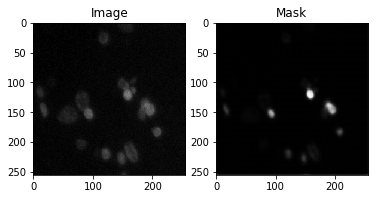

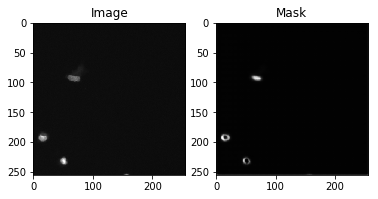

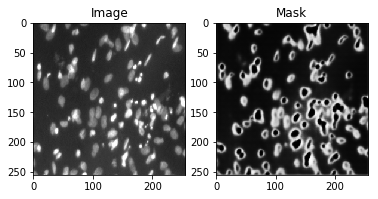

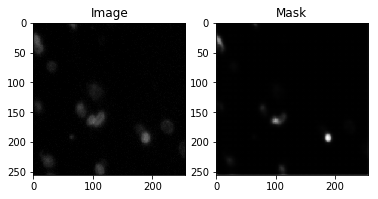

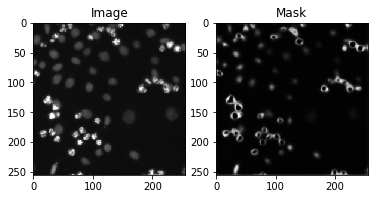

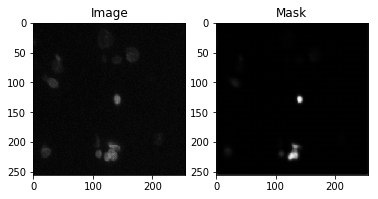

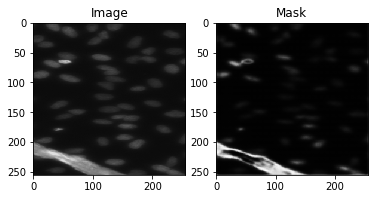

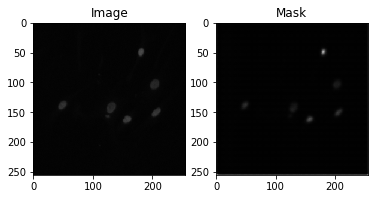

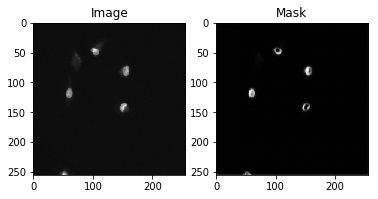

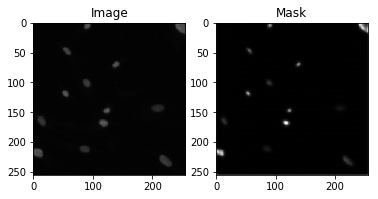

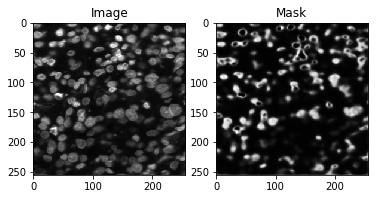

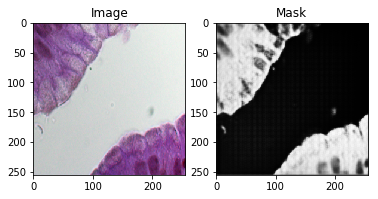

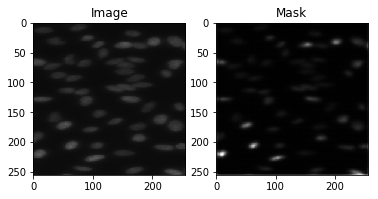

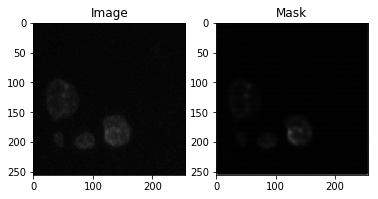

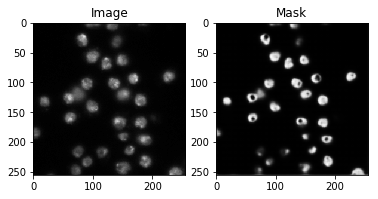

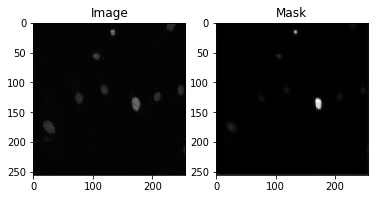

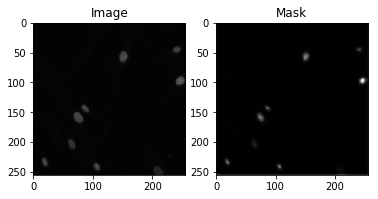

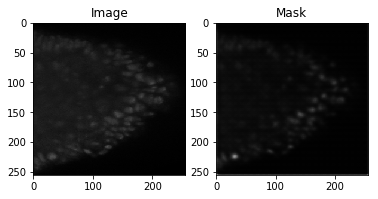

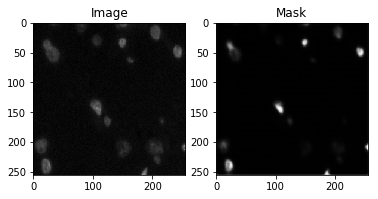

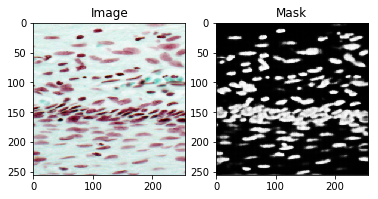

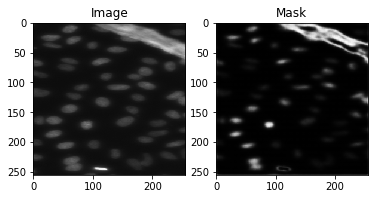

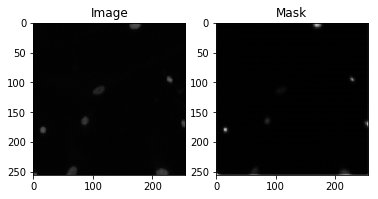

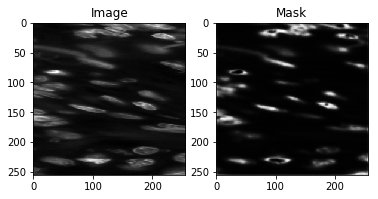

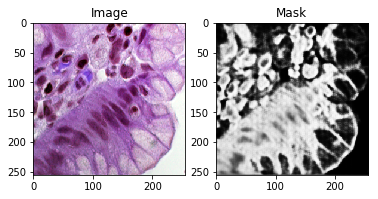

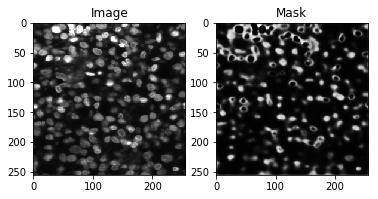

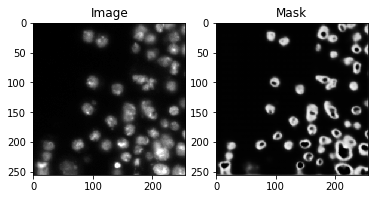

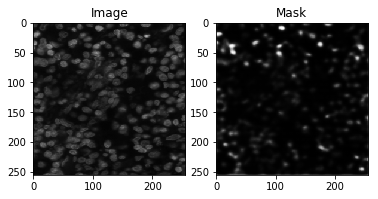

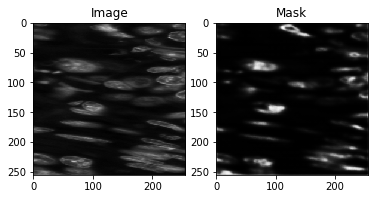

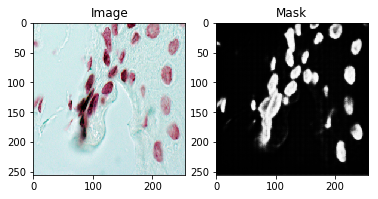

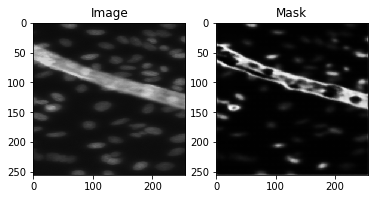

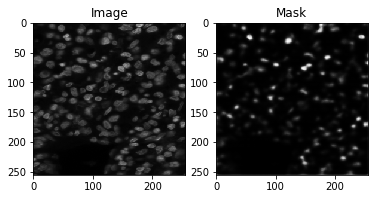

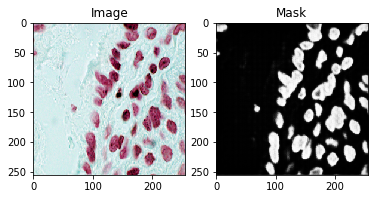

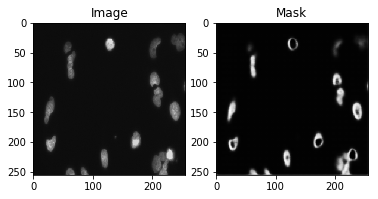

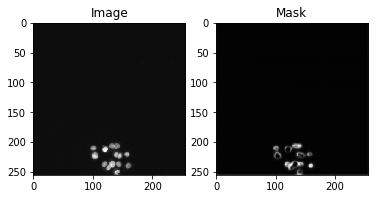

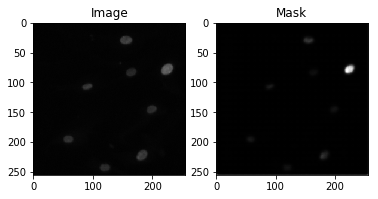

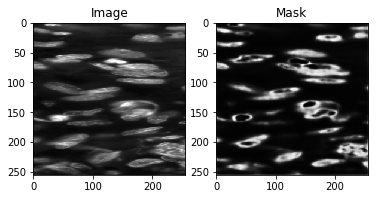

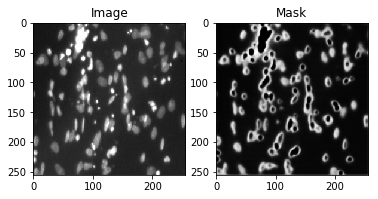

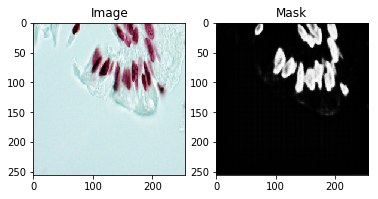

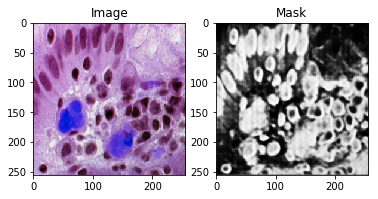

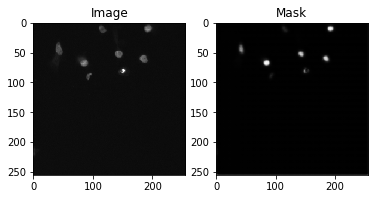

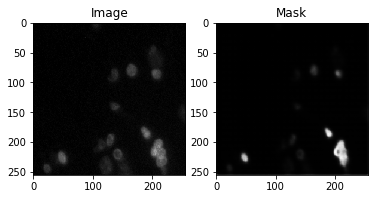

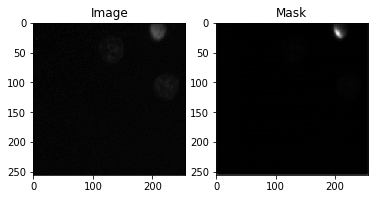

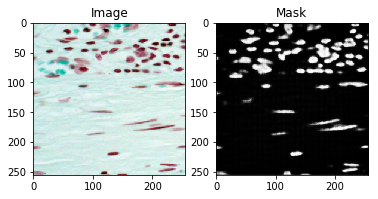

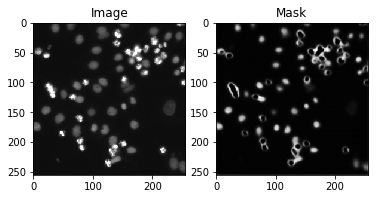

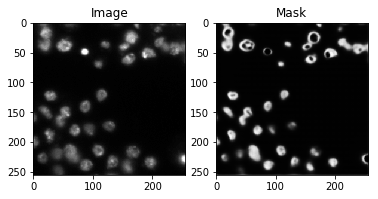

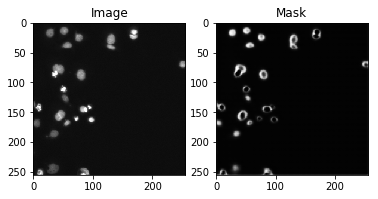

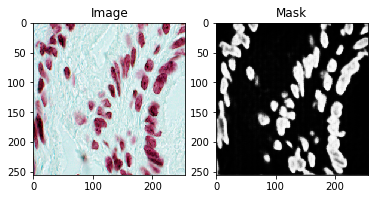

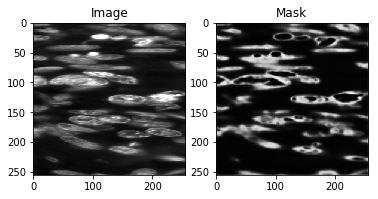

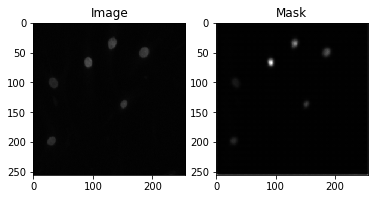

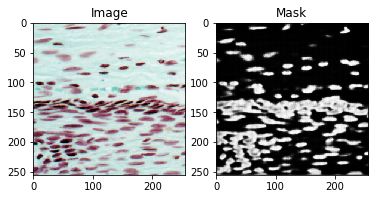

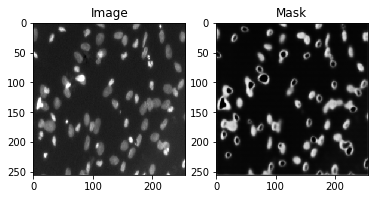

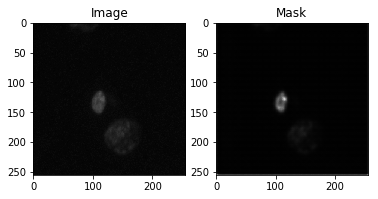

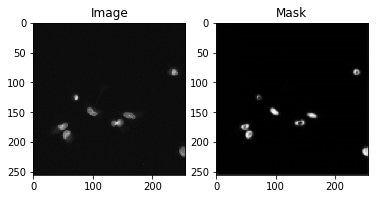

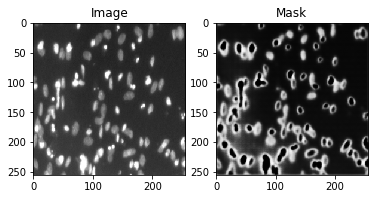

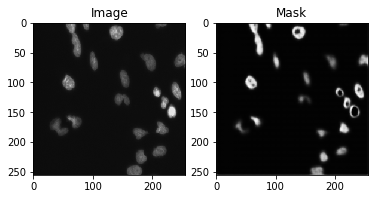

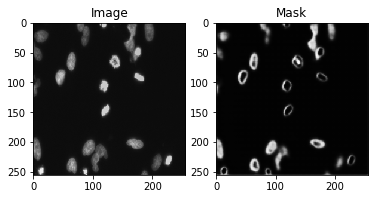

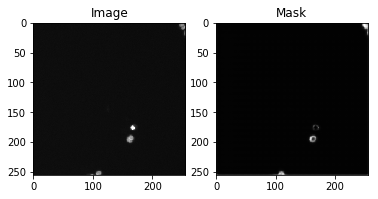

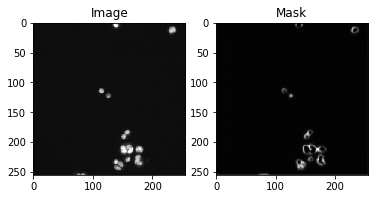

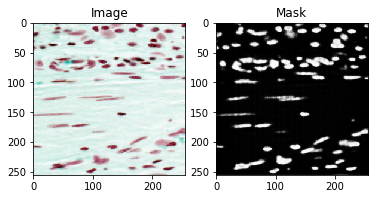

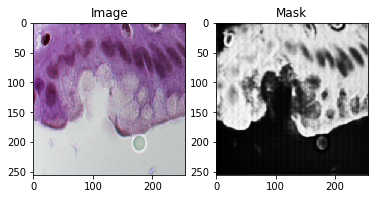

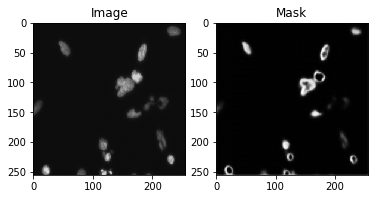

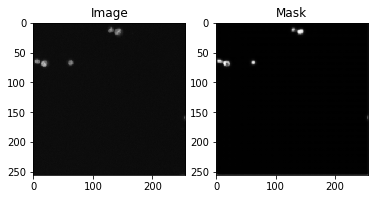

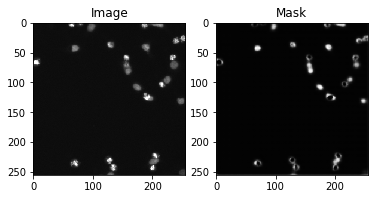

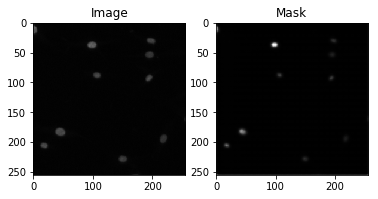

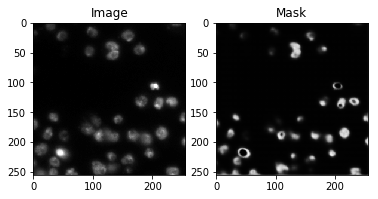

In [149]:
#Inference

import tensorflow as tf
import cv2
from scipy.ndimage.measurements import label
import matplotlib.pyplot as plt
import numpy as np

tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape=[None, 256, 256, 3], name="image")

# for img_file in glob("./test1/*/images/*.png"):
# # img_file = "./test1/1879f4f4f05e2bada0ffeb46c128b8df7a79b14c84f38c3e216a69653495153b/images/1879f4f4f05e2bada0ffeb46c128b8df7a79b14c84f38c3e216a69653495153b.png"
#     img = cv2.imread(img_file)
#     # img = x_val[75]
#     # mask = y_val[1]
#     print(np.shape(img))
#     img = cv2.resize(img, (256, 256))
# #     plt.imshow(img)
# #     plt.show()
#     img = np.asarray(img)
#     # print(img.shape)
#     img = np.reshape(img, (256, 256, 3))
pred = build_Uet(X, False)
# pred = network.make_unet(X, False)
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    ckpt = tf.train.get_checkpoint_state("model")
    saver.restore(sess, "model/model-epoch500.ckpt")
    
    for img_file in glob("./test1/*/images/*.png"):
        img = cv2.imread(img_file)
        # img = x_val[75]
        # mask = y_val[1]
#         print(np.shape(img))
        img = cv2.resize(img, (256, 256))
#         plt.imshow(img)
#         plt.show()
        img = np.asarray(img)
        # print(img.shape)
        img = np.reshape(img, (256, 256, 3))
        mask_pred = sess.run(pred, feed_dict={X:[img]})
        mask_pred = np.squeeze(mask_pred)
    #     mask_pred = mask_pred > 0.075
        f, axarr = plt.subplots(1,2)
        axarr[0].title.set_text('Image')
        axarr[1].title.set_text('Mask')
        axarr[0].imshow(img)
        axarr[1].imshow(mask_pred, cmap='gray')
#         plt.imshow(mask_pred, cmap='gray')
#         plt.show()
#     labeled_heatmap, n_labels = label(mask_pred)
#     bbox = []
#     for i in range(n_labels):
#         mask_i = labeled_heatmap == (i + 1)
#         nonzero = np.nonzero(mask_i)
#         nonzero_row = nonzero[0]
#         nonzero_col = nonzero[1]
#         left_top = min(nonzero_col), min(nonzero_row)
#         right_bot = max(nonzero_col), max(nonzero_row)
#         image = cv2.rectangle(img, left_top, right_bot, color=(0, 255, 0), thickness=2)      
#         bbox.append((left_top, right_bot))
#     print(image.shape)
#     plt.imshow(cv2.resize(image, (256, 256)), cmap='gray')
#     plt.show()
